In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import openai
from openai import OpenAI
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt

import warnings
warnings.filterwarnings("ignore")

In [198]:
df = pd.read_csv("Data/commonsense_qa.csv")

In [311]:
# Read the API key from the file
with open('api_key.txt', 'r') as file:
    api_key = file.read().strip()

# Set the API key in the OpenAI library
openai.api_key = api_key

# Define the model to use
GPT_MODEL = "gpt-3.5-turbo-0613"

In [35]:
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model = GPT_MODEL):
    """
    Sends request to the OpenAI API to generate chat completions based on the provided messages.

    Parameters:
    - messages (list): A list of message dictionaries to be sent to the chat completion model.
    - tools (list, optional): A list of tools that can be utilized for generating completions.
    - tool_choice (str, optional): A specific tool choice to influence the completion generation.
    - model (str): The model to be used for generating completions.

    Returns:
    - dict: The JSON response from the API containing the completion if the request is successful.

    Raises:
    - Exception: If the request fails after the maximum number of retry attempts, it raises and
      returns the exception, and prints an error message to the console.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages}

    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
        
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response.json() 
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

# Zero-Shot Prompting

In [41]:
def zero_shot_question(question, choices):
    """
    Asks a multiple-choice question using the OpenAI API and returns the assistant's response.
    
    Parameters:
    - question (str): The question to be asked.
    - choices (dict): Dictionary of choices where keys are option labels and values are the options' text.
    
    Returns:
    - str: The assistant's response as determined by the OpenAI API.
    """
    messages = [
        {"role": "system", "content": """You will be presented with a question that contains several possiable answers.
         Choose the most suitable option from 'A', 'B', 'C', 'D' or 'E' based on your common sense.
         Please give your answer in a single form letter."""},
        {"role": "assistant", "content": question},
        {"role": "assistant", "content": f"A) {choices['choice_A']} B) {choices['choice_B']} C) {choices['choice_C']} D) {choices['choice_D']} E) {choices['choice_E']}"}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"]
    return assistant_message


In [42]:
responses = []
for index, row in df.iterrows():
    question = row["question"]
    choices = {
        "choice_A": row["choice_A"],
        "choice_B": row["choice_B"],
        "choice_C": row["choice_C"],
        "choice_D": row["choice_D"],
        "choice_E": row["choice_E"]
    }
    response = zero_shot_question(question, choices)
    responses.append(response)

df["responses_en_ZS"] = responses

In [43]:
responses = []
for index, row in df.iterrows():
    question = row["question_arm"]
    choices = {
        "choice_A": row["choice_A_arm"],
        "choice_B": row["choice_B_arm"],
        "choice_C": row["choice_C_arm"],
        "choice_D": row["choice_D_arm"],
        "choice_E": row["choice_E_arm"]
    }
    response = zero_shot_question(question, choices)
    responses.append(response)

df["responses_arm_ZS"] = responses

In [44]:
df.to_csv("Data/commonsense_qa.csv", index=False)

# One-Shot Prompting

In [47]:
def one_shot_question(question, choices, example):
    """
    Asks a multiple-choice question using the OpenAI API and returns the assistant's response, using 
    one-shot prompting with an external example.

    Parameters:
    - question (str): The question to ask.
    - choices (dict): Dictionary of choices where keys are option labels and values are the options' text.
    - example (str): The example provided to guide the user.
    
    Returns:
    str: The assistant's response as determined by the OpenAI API.
    """
    full_prompt = (
        f"Example:\n{example}\n"
        "Now answer this:\n"
        f"Q: {question}\n"
        "Options:\n"
        f"A) {choices['choice_A']}\n"
        f"B) {choices['choice_B']}\n"
        f"C) {choices['choice_C']}\n"
        f"D) {choices['choice_D']}\n"
        f"E) {choices['choice_E']}"
    )
    messages = [
        {"role": "system", "content": "You will be presented with a question and several possible answers. An example has been provided to guide you. After reviewing the example, please choose the most suitable option from 'A', 'B', 'C', 'D', or 'E' for the real question based on your best judgement."},
        {"role": "assistant", "content": full_prompt}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"]
    return assistant_message


In [55]:
example_text_en = (
    "Q: When you want to cross the street safely at a traffic light, which light should you wait for before crossing?\n"
    "Options:\n"
    "A) Red light for pedestrians\n"
    "B) Green light for pedestrians.\n"
    "C) Yellow light for cars.\n"
    "D) Red light for cars.\n"
    "E) Green light for the cars\n"
    "B"
)

example_text_arm = (
    "Հարց: Երբ ցանկանում ես փողոցն ապահով անցնել լուսացույցի լույսի տակ, ո՞ր լույսին պետք է սպասել անցնելուց առաջ։\n"
    "Տարբերակներ:\n"
    "A) Կարմիր լույսին հետիոտների համար։\n"
    "B) Կանաչ լույսին հետիոտների համար։\n"
    "C) Դեղին լույսին մեքենաների համար։\n"
    "D) Կարմիր լուսին մեքենաների համար։\n"
    "E) Կանաչ լույսին մեքենաների համար։\n"
    "B"
)

In [49]:
def apply_one_shot_to_df(df, question_col, choice_cols, example, response_col):
    """
    Applies one-shot question answering to specified columns of a DataFrame,
    using an external example to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - choice_cols (list): List of column names that contain the multiple choice options.
    - example (str): The example provided to guide the model.
    - response_col (str): Name of the column where the responses will be stored.
    """

    for index, row in df.iterrows():
        choices = {f'choice_{chr(65+i)}': row[col] for i, col in enumerate(choice_cols)}
        response = one_shot_question(row[question_col], choices, example)
        
        df.at[index, response_col] = response

    df.to_csv('Data/commonsense_qa.csv', index=False)


In [56]:
apply_one_shot_to_df(df, 'question', ['choice_A', 'choice_B', 'choice_C', 'choice_D', 'choice_E'], example_text_en, 'response_en_OS')
apply_one_shot_to_df(df, 'question_arm', ['choice_A_arm', 'choice_B_arm', 'choice_C_arm', 'choice_D_arm', 'choice_E_arm'], example_text_arm, 'response_arm_OS')

# Few-Shot Prompting

In [61]:
def few_shot_question(question, choices, examples):
    """
    Asks a multiple-choice question using the OpenAI API and returns the assistant's response, using 
    few-shot prompting with multiple external examples.

    Parameters:
    - question (str): The question to ask.
    - choices (dict): Dictionary of choices where keys are option labels and values are the options' text.
    - examples (list of str): List of formatted examples to guide the model.

    Returns:
    str: The assistant's response as determined by the OpenAI API.
    """
    few_shot_examples = "\n\n".join(examples) + "\nNow answer this:\n"
    real_question_prompt = (
        f"Q: {question}\n"
        "Options:\n" +
        "".join([f"{chr(65+i)}) {choices[f'choice_{chr(65+i)}']}\n" for i in range(len(choices))])
    )
    full_prompt = few_shot_examples + real_question_prompt
    messages = [
        {"role": "system", "content": "You are to answer the following question based on the provided examples. Choose the most appropriate answer from the options."},
        {"role": "assistant", "content": full_prompt}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"]
    return assistant_message

In [62]:
few_shot_examples_en = (
    "Q: Why should you wear a seat belt when driving a car?\n"
    "Options:\n"
    "A) It's more comfortable\n"
    "B) It keeps you safe in case of an accident\n"
    "C) It makes the car go faster\n"
    "D) It plays music\n"
    "E) To make a fashion statement\n"
    "B\n"
    
    "Q: Who wrote 'Pride and Prejudice'?\n"
    "Options:\n"
    "A) Emily Bronte\n"
    "B) Jane Austen\n"
    "C) Charles Dickens\n"
    "D) Mark Twain\n"
    "E) George Orwell\n"
    "B"

    "Q: Why do people use umbrellas?\n"
    "Options:\n"
    "A) To start exercising\n"
    "B) It's a color that is easy to see\n"
    "C) To wear them to a wedding\n"
    "D) To protect themselves from rain or sun\n"
    "E) To fly like Mary Poppins\n"
    "D" 
)

few_shot_examples_arm = (
    "Հարց. Ինչո՞ւ է պետք ամրագոտին կապել մեքենա վարելիս:\n"
    "Տարբերակներ.\n"
    "A) Ավելի հարմար է\n"
    "B) Այն ձեզ ապահով կպահի վթարի դեպքում\n"
    "C) Դա ստիպում է մեքենաին ավելի արագ գնալ\n"
    "D) Երաժշտություն է նվագում\n"
    "E) Նորաձևության հայտարարություն անել\n"
    "B\n"

    "Հարց. Ո՞վ է գրել «Հպարտություն և նախապաշարմունք»-ը:\n"
    "Տարբերակներ.\n"
    "A) Էմիլի Բրոնտե\n"
    "B) Ջեյն Օսթին\n"
    "C) Չարլզ Դիքենս\n"
    "D) Մարկ Տվեն\n"
    "E) Ջորջ Օրուել\n"
    "B\n"
    
    "Հարց. Ինչո՞ւ են մարդիկ հովանոցներ օգտագործում:\n"
    "Տարբերակներ.\n"
    "A) Սկսել մարզվել\n"
    "B) Դա գույն է, որը հեշտ է տեսնել\n"
    "C) Հագնել հարսանիքին\n"
    "D) Անձրևից կամ արևից պաշտպանվելու համար\n"
    "E) Մերի Փոփինսի պես թռչել\n"
    "D"
)

In [63]:
def apply_few_shot_to_df(df, question_col, choice_cols, examples, response_col):
    """
    Applies few-shot question answering to specified columns of a DataFrame,
    using multiple external examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - choice_cols (list of str): List of column names that contain the multiple choice options.
    - examples (list of str): A list of formatted examples.
    - response_col (str): Name of the column where the responses will be stored.
    """
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        # Construct the choices dictionary dynamically
        choices = {f'choice_{chr(65+i)}': row[col] for i, col in enumerate(choice_cols)}

        # Call the few_shot_question function
        response = few_shot_question(row[question_col], choices, examples)

        # Store the response in the specified response column
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/commonsense_qa.csv', index=False)

In [66]:
apply_one_shot_to_df(df, 'question', ['choice_A', 'choice_B', 'choice_C', 'choice_D', 'choice_E'], few_shot_examples_en, 'response_en_FS')
apply_one_shot_to_df(df, 'question_arm', ['choice_A_arm', 'choice_B_arm', 'choice_C_arm', 'choice_D_arm', 'choice_E_arm'], few_shot_examples_arm, 'response_arm_FS')

# Using Armenian as the language of system_message

## Zero-Shot

In [242]:
def zero_shot_question_arm(question, choices):
    """
    Asks a multiple-choice question using the OpenAI API and returns the assistant's response.
    
    Parameters:
    - question (str): The question to be asked.
    - choices (dict): Dictionary of choices where keys are option labels and values are the options' text.
    
    Returns:
    str: The assistant's response as determined by the OpenAI API.
    """
    messages = [
        {"role": "system", "content": """Քեզ կտրվի հարց, որը պարունակում է մի քանի հնարավոր պատասխաններ։ Ընտրիր ամենահամապատասխան տարբերակը 'A', 'B', 'C', 'D' կամ 'E'-ից հիմնվելով քո դատողության վրա։
         Պատասխանը պետք է լինի ընտրված տարբերակի տառը։"""},
        {"role": "assistant", "content": question},
        {"role": "assistant", "content": f"A) {choices['choice_A']} B) {choices['choice_B']} C) {choices['choice_C']} D) {choices['choice_D']} E) {choices['choice_E']}"}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"]
    return assistant_message

In [243]:
def apply_zero_shot_to_df_arm(df, question_col, choice_cols, response_col):
    """
    Applies few-shot question answering to specified columns of a DataFrame,
    using multiple external examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - choice_cols (list of str): List of column names that contain the multiple choice options.
    - response_col (str): Name of the column where the responses will be stored.
    """
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        # Construct the choices dictionary dynamically
        choices = {f'choice_{chr(65+i)}': row[col] for i, col in enumerate(choice_cols)}

        # Call the few_shot_question function
        response = zero_shot_question_arm(row[question_col], choices)

        # Store the response in the specified response column
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/commonsense_qa.csv', index=False)

In [244]:
apply_zero_shot_to_df_arm(df, 'question_arm', ['choice_A_arm', 'choice_B_arm', 'choice_C_arm', 'choice_D_arm', 'choice_E_arm'], 'response_arm_sys_ZS')


## One-Shot

In [245]:
def one_shot_question_arm(question, choices, example):
    """
    Asks a multiple-choice question using the OpenAI API and returns the assistant's response, using 
    one-shot prompting with an external example.

    Parameters:
    - question (str): The question to ask.
    - choices (dict): Dictionary of choices where keys are option labels and values are the options' text.
    - example (str): The example provided to guide the user.
    
    Returns:
    str: The assistant's response as determined by the OpenAI API.
    """
    full_prompt = (
        f"Example:\n{example}\n"
        "Now answer this:\n"
        f"Q: {question}\n"
        "Options:\n"
        f"A) {choices['choice_A']}\n"
        f"B) {choices['choice_B']}\n"
        f"C) {choices['choice_C']}\n"
        f"D) {choices['choice_D']}\n"
        f"E) {choices['choice_E']}"
    )
    messages = [
        {"role": "system", "content": """Քեզ կտրվի հարց, որը պարունակում է մի քանի հնարավոր պատասխաններ։ Ընտրիր ամենահամապատասխան տարբերակը 'A', 'B', 'C', 'D' կամ 'E'-ից հիմնվելով քո դատողության վրա։
         Պատասխանը պետք է լինի ընտրված տարբերակի տառը։"""},
        {"role": "assistant", "content": full_prompt}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"]
    return assistant_message

In [246]:
def apply_one_shot_to_df_arm(df, question_col, choice_cols, example, response_col):
    """
    Applies one-shot question answering to specified columns of a DataFrame,
    using an external example to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - choice_cols (list): List of column names that contain the multiple choice options.
    - example (str): The example provided to guide the model.
    - response_col (str): Name of the column where the responses will be stored.
    """

    for index, row in df.iterrows():
        choices = {f'choice_{chr(65+i)}': row[col] for i, col in enumerate(choice_cols)}
        response = one_shot_question_arm(row[question_col], choices, example)
        
        df.at[index, response_col] = response

    df.to_csv('Data/commonsense_qa.csv', index=False)

In [247]:
apply_one_shot_to_df_arm(df, 'question_arm', ['choice_A_arm', 'choice_B_arm', 'choice_C_arm', 'choice_D_arm', 'choice_E_arm'], example_text_arm, 'response_arm_sys_OS')

## Few-Shot

In [248]:
def few_shot_question_arm(question, choices, examples):
    """
    Asks a multiple-choice question using the OpenAI API and returns the assistant's response, using 
    few-shot prompting with multiple external examples.

    Parameters:
    question (str): The question to ask.
    choices (dict): Dictionary of choices where keys are option labels and values are the options' text.
    examples (list of str): List of formatted examples to guide the model.

    Returns:
    str: The assistant's response as determined by the OpenAI API.
    """
    few_shot_examples = "\n\n".join(examples) + "\nNow answer this:\n"
    real_question_prompt = (
        f"Q: {question}\n"
        "Options:\n" +
        "".join([f"{chr(65+i)}) {choices[f'choice_{chr(65+i)}']}\n" for i in range(len(choices))])
    )
    full_prompt = few_shot_examples + real_question_prompt
    messages = [
        {"role": "system", "content": """Քեզ կտրվի հարց, որը պարունակում է մի քանի հնարավոր պատասխաններ։ Ընտրիր ամենահամապատասխան տարբերակը 'A', 'B', 'C', 'D' կամ 'E'-ից հիմնվելով քո դատողության վրա։
         Պատասխանը պետք է լինի ընտրված տարբերակի տառը։"""},
        {"role": "assistant", "content": full_prompt}
    ]
    chat_response = chat_completion_request(messages)
    assistant_message = chat_response["choices"][0]["message"]["content"]
    return assistant_message

In [249]:
def apply_few_shot_to_df_arm(df, question_col, choice_cols, examples, response_col):
    """
    Applies few-shot question answering to specified columns of a DataFrame,
    using multiple external examples to guide the model, and stores the responses in a new column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - question_col (str): Name of the column containing the questions.
    - choice_cols (list of str): List of column names that contain the multiple choice options.
    - examples (list of str): A list of formatted examples.
    - response_col (str): Name of the column where the responses will be stored.
    """
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        # Construct the choices dictionary dynamically
        choices = {f'choice_{chr(65+i)}': row[col] for i, col in enumerate(choice_cols)}

        # Call the few_shot_question function
        response = few_shot_question_arm(row[question_col], choices, examples)

        # Store the response in the specified response column
        df.at[index, response_col] = response

    # Save the DataFrame after updating
    df.to_csv('Data/commonsense_qa.csv', index=False)

In [250]:
apply_few_shot_to_df_arm(df, 'question_arm', ['choice_A_arm', 'choice_B_arm', 'choice_C_arm', 'choice_D_arm', 'choice_E_arm'], few_shot_examples_arm, 'response_arm_sys_FS')

In [287]:
def process_responses(df, response_columns):
    """
    Processes multiple response columns in a DataFrame to extract letters A to E (standalone or in various formats),
    but avoids splitting when formatted as 'A)', 'B)', etc. Adds two new columns for each response column to store
    the extracted letter and the remaining text.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - response_columns (list of str): List of column names containing the full responses.
    """
    # Check if df is indeed a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    for response_column in response_columns:
        letter_column = f'{response_column}_letter'
        text_column = f'{response_column}_text'

        # Initialize new columns
        df[letter_column] = None
        df[text_column] = None

        # Iterate over rows
        for index, row in df.iterrows():
            text = row[response_column]
            if pd.notna(text):
                # Check if the format is exactly 'Letter)' to avoid splitting
                if re.match("^[ABCDE]\)$", text.strip()):
                    df.at[index, letter_column] = text[0]
                    df.at[index, text_column] = ""
                else:
                    # Splitting the text on the first occurrence of ')' if it's not just 'Letter)'
                    split_text = text.split(')', 1)
                    df.at[index, letter_column] = split_text[0].strip() if len(split_text[0].strip()) == 1 and split_text[0].strip() in "ABCDE" else None
                    df.at[index, text_column] = split_text[1].strip() if len(split_text) > 1 else ""

    return df

In [288]:
process_responses(df, ["responses_en_ZS"])
process_responses(df, ["response_en_OS"])
process_responses(df, ["response_en_FS"])
process_responses(df, ["responses_arm_ZS"])
process_responses(df, ["response_arm_OS"])
process_responses(df, ["response_arm_FS"])
process_responses(df, ["response_arm_sys_ZS"])
process_responses(df, ["response_arm_sys_OS"])
process_responses(df, ["response_arm_sys_FS"])
df.head(1)

,question,question_concept,choices,answerKey,choice_A,choice_B,choice_C,choice_D,choice_E,question_arm,...,response_arm_OS_letter,response_arm_OS_text,response_arm_FS_letter,response_arm_FS_text,response_arm_sys_ZS_letter,response_arm_sys_ZS_text,response_arm_sys_OS_letter,response_arm_sys_OS_text,response_arm_sys_FS_letter,response_arm_sys_FS_text
0,"Bill sits down on a whoopee cushion, what soun...",sitting down,"{'label': array(['A', 'B', 'C', 'D', 'E'], dty...",B,fall asleep,flatulence,sigh of relief,medium,comfort,"Բիլլը նստում է բարձիկի վրա, ի՞նչ ձայն է նա նստ...",...,A,"քնել, քնով անցնել\nB) փքվածություն\nC) թեթեւաց...",E,հարմարավետություն,None,մեկը B) երկուսը C) երեքը D) չի քանիսացում,A,"քնել, քնով անցնել",A,"քնել, քնով անցնել"


In [289]:
df.to_csv("Data/commonsense_qa.csv", index=False)

## Accuracy

In [294]:
df['accur_responses_en_ZS_letter'] = df['responses_en_ZS_letter'] == df['answerKey']
accuracy_ZS_en = df['accur_responses_en_ZS_letter'].mean() * 100

df['accur_responses_en_OS_letter'] = df['response_en_OS_letter'] == df['answerKey']
accuracy_OS_en = df['accur_responses_en_OS_letter'].mean() * 100

df['accur_responses_en_FS_letter'] = df['response_en_FS_letter'] == df['answerKey']
accuracy_FS_en = df['accur_responses_en_FS_letter'].mean() * 100

print(f"Accuracy of zero-shot English: {accuracy_ZS_en}%")
print(f"Accuracy of one-shot English: {accuracy_OS_en}%")
print(f"Accuracy of few-shot English: {accuracy_FS_en}%")

Accuracy of zero-shot English: 76.0%
Accuracy of one-shot English: 64.0%
Accuracy of few-shot English: 66.0%


In [296]:
df['accur_responses_arm_ZS_letter'] = df['responses_arm_ZS_letter'] == df['answerKey']
accuracy_ZS_arm = df['accur_responses_arm_ZS_letter'].mean() * 100

df['accur_responses_arm_OS_letter'] = df['response_arm_OS_letter'] == df['answerKey']
accuracy_OS_arm = df['accur_responses_arm_OS_letter'].mean() * 100

df['accur_responses_arm_FS_letter'] = df['response_arm_FS_letter'] == df['answerKey']
accuracy_FS_arm = df['accur_responses_arm_FS_letter'].mean() * 100

print(f"Accuracy of zero-shot Armenian: {accuracy_ZS_arm}%")
print(f"Accuracy of one-shot Armenian: {accuracy_OS_arm}%")
print(f"Accuracy of few-shot Armenian: {accuracy_FS_arm}%")

Accuracy of zero-shot Armenian: 26.0%
Accuracy of one-shot Armenian: 8.0%
Accuracy of few-shot Armenian: 14.000000000000002%


In [299]:
df['accur_responses_arm_sys_ZS_letter'] = df['response_arm_sys_ZS_letter'] == df['answerKey']
accuracy_ZS_arm_sys = df['accur_responses_arm_sys_ZS_letter'].mean() * 100

df['accur_responses_arm_sys_OS_letter'] = df['response_arm_sys_OS_letter'] == df['answerKey']
accuracy_OS_arm_sys = df['accur_responses_arm_sys_OS_letter'].mean() * 100

df['accur_responses_arm_sys_FS_letter'] = df['response_arm_sys_FS_letter'] == df['answerKey']
accuracy_FS_arm_sys = df['accur_responses_arm_sys_FS_letter'].mean() * 100

print(f"Accuracy of zero-shot Armenian 2: {accuracy_ZS_arm_sys}%")
print(f"Accuracy of one-shot Armenian 2: {accuracy_OS_arm_sys}%")
print(f"Accuracy of few-shot Armenian 2: {accuracy_FS_arm_sys}%")

Accuracy of zero-shot Armenian 2: 4.0%
Accuracy of one-shot Armenian 2: 6.0%
Accuracy of few-shot Armenian 2: 20.0%


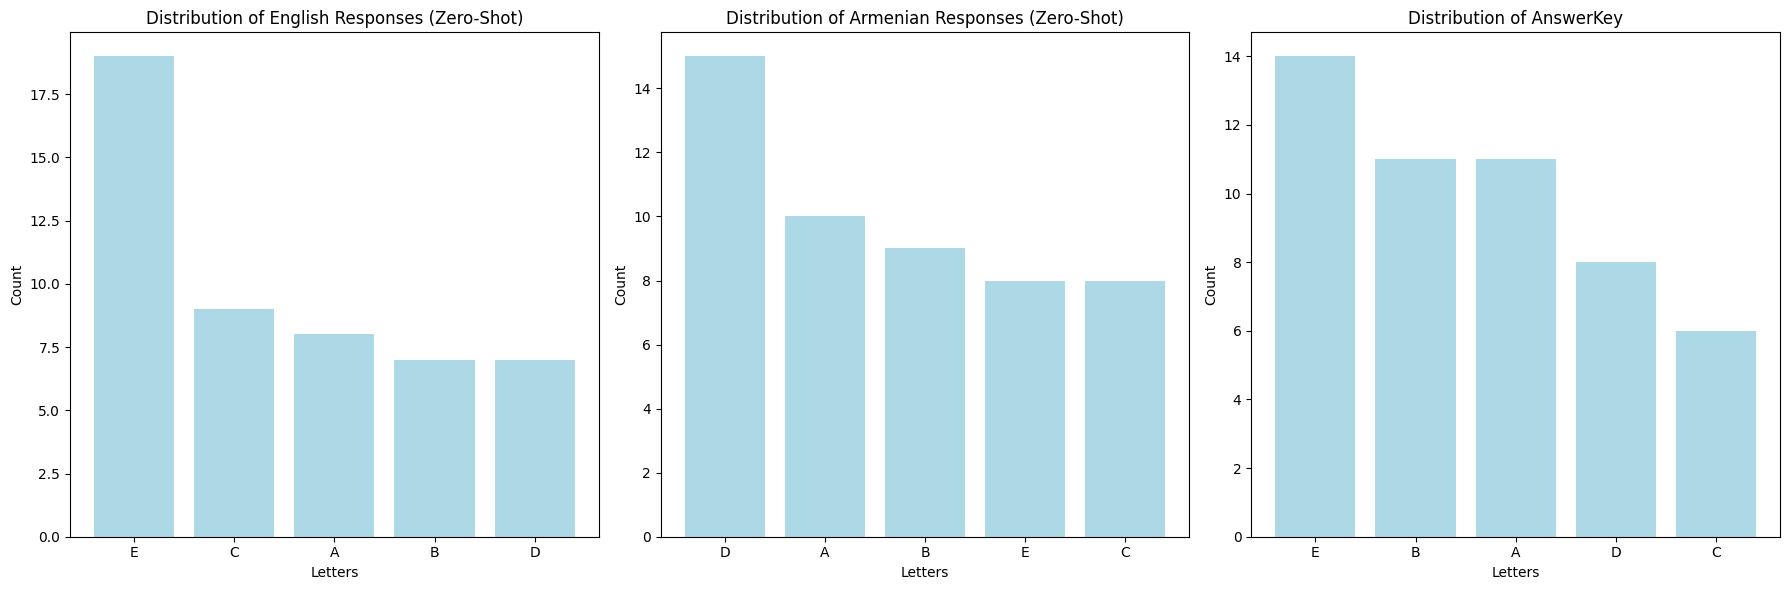

In [300]:
# Plot for comparing zero-shot with answerKey
answer_counts_en_ZS = df['responses_en_ZS_letter'].value_counts()
answer_counts_arm_ZS = df['responses_arm_ZS_letter'].value_counts()
answer_counts_answerKey = df['answerKey'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Plot the distribution of English responses ZS
axs[0].bar(answer_counts_en_ZS.index, answer_counts_en_ZS.values, color='lightblue')
axs[0].set_xlabel('Letters')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of English Responses (Zero-Shot)')

# Plot the distribution of Armenian responses ZS
axs[1].bar(answer_counts_arm_ZS.index, answer_counts_arm_ZS.values, color='lightblue')
axs[1].set_xlabel('Letters')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Armenian Responses (Zero-Shot)')

# Plot the distribution of AnswerKey
axs[2].bar(answer_counts_answerKey.index, answer_counts_answerKey.values, color='lightblue')
axs[2].set_xlabel('Letters')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of AnswerKey')

plt.tight_layout()
plt.savefig('dist_MC_questions_ZS_and_answerKey.png') 
plt.show()


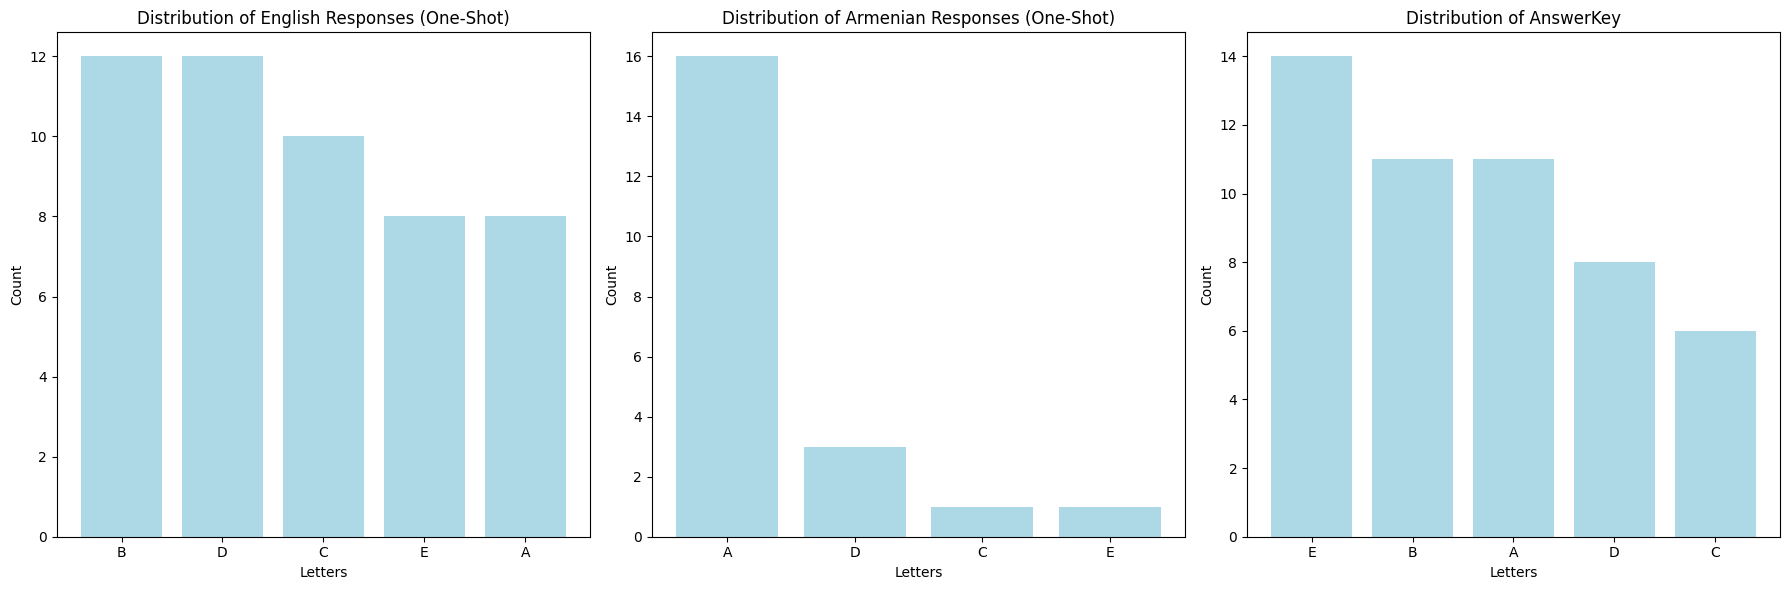

In [303]:
# Plot for comparing one-shot with answerKey
answer_counts_en_OS = df['response_en_OS_letter'].value_counts()
answer_counts_arm_OS = df['response_arm_OS_letter'].value_counts()
answer_counts_answerKey = df['answerKey'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Plot the distribution of English responses OS
axs[0].bar(answer_counts_en_OS.index, answer_counts_en_OS.values, color='lightblue')
axs[0].set_xlabel('Letters')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of English Responses (One-Shot)')

# Plot the distribution of Armenian responses OS
axs[1].bar(answer_counts_arm_OS.index, answer_counts_arm_OS.values, color='lightblue')
axs[1].set_xlabel('Letters')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Armenian Responses (One-Shot)')

# Plot the distribution of AnswerKey
axs[2].bar(answer_counts_answerKey.index, answer_counts_answerKey.values, color='lightblue')
axs[2].set_xlabel('Letters')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of AnswerKey')

plt.tight_layout()
plt.show()

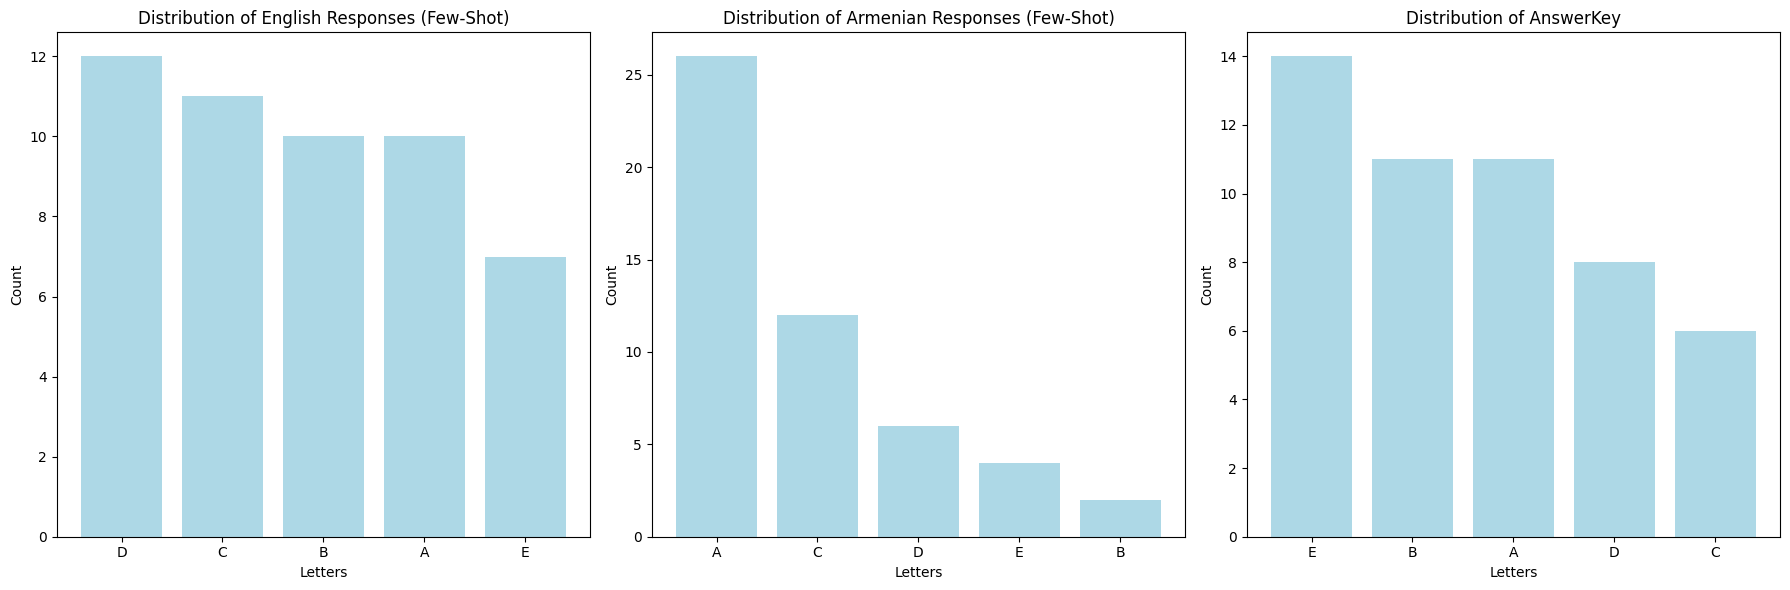

In [197]:
# Plot for comparing few-shot with answerKey
answer_counts_en_FS = df['responses_en_FS_letter'].value_counts()
answer_counts_arm_FS = df['responses_arm_FS_letter'].value_counts()
answer_counts_answerKey = df['answerKey'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Plot the distribution of English responses OS
axs[0].bar(answer_counts_en_FS.index, answer_counts_en_FS.values, color='lightblue')
axs[0].set_xlabel('Letters')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of English Responses (Few-Shot)')

# Plot the distribution of Armenian responses OS
axs[1].bar(answer_counts_arm_FS.index, answer_counts_arm_FS.values, color='lightblue')
axs[1].set_xlabel('Letters')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Armenian Responses (Few-Shot)')

# Plot the distribution of AnswerKey
axs[2].bar(answer_counts_answerKey.index, answer_counts_answerKey.values, color='lightblue')
axs[2].set_xlabel('Letters')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of AnswerKey')

plt.tight_layout()
plt.show()

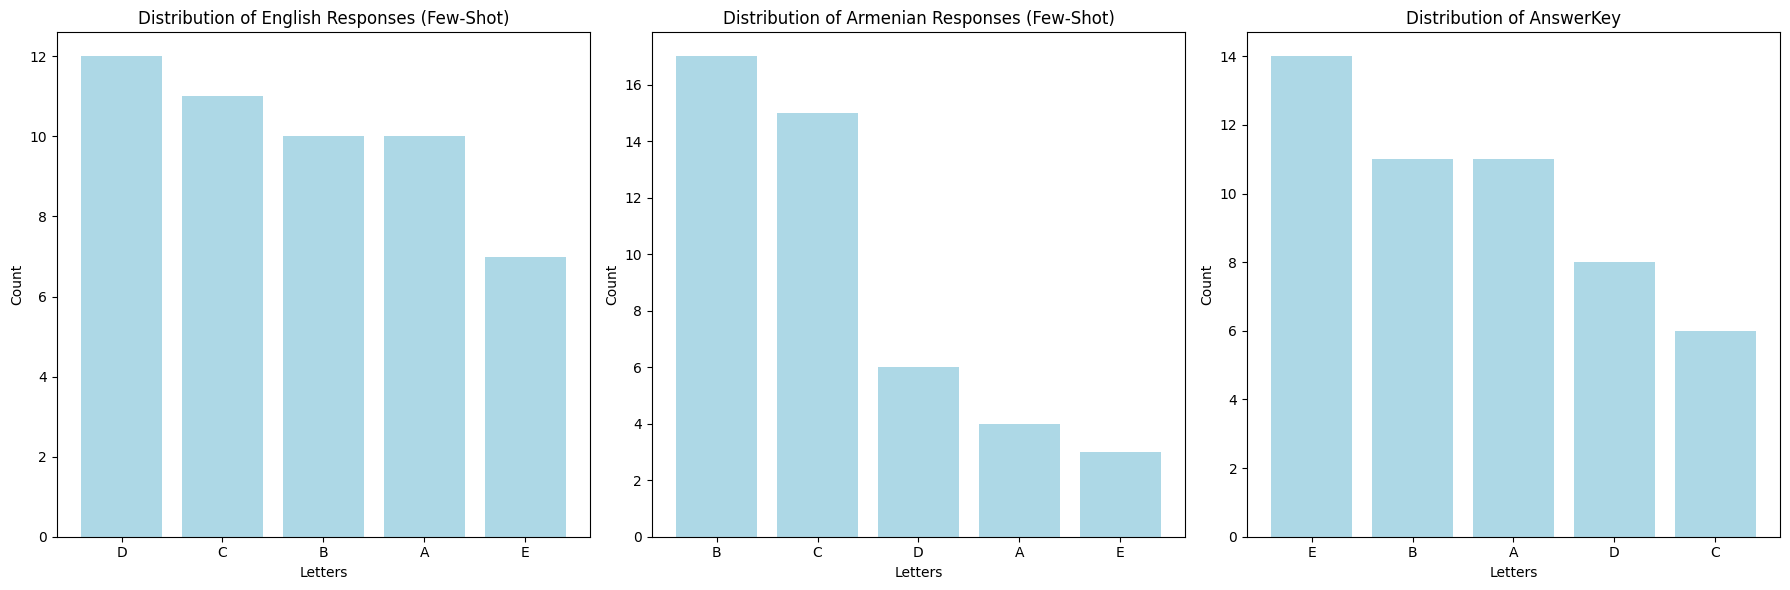

In [310]:
# System message Armenian
# Plot for comparing few-shot with answerKey
answer_counts_en_FS = df['response_en_FS_letter'].value_counts()
answer_counts_arm_FS = df['response_arm_sys_FS_letter'].value_counts()
answer_counts_answerKey = df['answerKey'].value_counts()

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Plot the distribution of English responses OS
axs[0].bar(answer_counts_en_FS.index, answer_counts_en_FS.values, color='lightblue')
axs[0].set_xlabel('Letters')
axs[0].set_ylabel('Count')
axs[0].set_title('Distribution of English Responses (Few-Shot)')

# Plot the distribution of Armenian responses OS
axs[1].bar(answer_counts_arm_FS.index, answer_counts_arm_FS.values, color='lightblue')
axs[1].set_xlabel('Letters')
axs[1].set_ylabel('Count')
axs[1].set_title('Distribution of Armenian Responses (Few-Shot)')

# Plot the distribution of AnswerKey
axs[2].bar(answer_counts_answerKey.index, answer_counts_answerKey.values, color='lightblue')
axs[2].set_xlabel('Letters')
axs[2].set_ylabel('Count')
axs[2].set_title('Distribution of AnswerKey')

plt.tight_layout()
plt.savefig('dist_MC_questions_FS_and_answerKey.png') 
plt.show()